## Importar Librerias

In [39]:
import cv2    
import math   
import matplotlib.pyplot as plt    
%matplotlib inline
import pandas as pd
from tensorflow.keras.preprocessing import image  
import numpy as np   
from skimage.transform import resize 
from glob import glob
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import load_img, img_to_array

from scipy import stats as s

## Cargar datos pre entrenados

In [40]:
train_split = pd.read_csv('./train_split.csv')
train_split.shape

(3000, 2)

In [41]:
train_split['class'].unique()

array(['play', 'challenge', 'throwin'], dtype=object)

In [42]:
import pickle

with open('./X.pkl','rb') as f:
    X = pickle.load(f)

In [43]:
X.shape

(3000, 224, 224, 3)

## Crear set de validacion

In [44]:
# separar el target
y = train_split['class']

# crear los sets de training y validacion 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [45]:
# Preparando las etiquetas
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [46]:
print(y_train.value_counts())
print(y_test.value_counts())

challenge  play  throwin
0          1     0          1993
1          0     0           312
0          0     1            95
dtype: int64
challenge  play  throwin
0          1     0          498
1          0     0           78
0          0     1           24
dtype: int64


In [47]:
y_test

,challenge,play,throwin
929,0,1,0
2753,0,1,0
884,0,1,0
843,0,1,0
1030,0,1,0
...,...,...,...
1725,0,1,0
534,0,1,0
2089,1,0,0
1500,0,1,0


In [48]:
# Shape del entrenamiento
y_train.shape

(2400, 3)

# Definir la arquitectura, el modelo y tranformar la data

In [49]:
# base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
# base_model.trainable = False

In [50]:
# Creando el modelo en base a uno ya entrenado, en este cada el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False)

In [51]:
# extraer features del training frame
X_train = base_model.predict(X_train)
X_train.shape

10/75 [===>..........................] - ETA: 1:56

In [ ]:
# Extraer features del set de testing
X_test = base_model.predict(X_test)
X_test.shape

19/19 [==============================] - 31s 2s/step


(600, 7, 7, 512)

In [ ]:
# transformar el training y validation set para extraer los frames en una dimension 
X_train = X_train.reshape(2400, 7*7*512)
X_test = X_test.reshape(600, 7*7*512)

In [ ]:
# normalizar los pixeles
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [ ]:
# encontrar el shape 
X_train.shape

(2400, 25088)

In [ ]:
# definir la arquitectura con las que vamos a trabajar
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.3))  # Reducir el dropout para evitar perder demasiadas características
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))


# Entrenar el modelo y guardar los pesos 

In [ ]:
# definir la menra de guardar los mejores pesos
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.0001)  # Reducir la tasa de aprendizaje
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# definir metrica de EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calcula los pesos para cada clase
class_weights = compute_class_weight('balanced', classes=np.unique(train_split['class']), y=train_split['class'])

# Convierte los pesos en un diccionario para pasarlo al entrenamiento del modelo
class_weight_dict = dict(enumerate(class_weights))

# Usa este diccionario de pesos en el método fit
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[mcp_save, es], batch_size=16, class_weight=class_weight_dict)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 1.2246 - accuracy: 0.3383

c:\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 16s 105ms/step - loss: 1.2246 - accuracy: 0.3383 - val_loss: 1.1584 - val_accuracy: 0.0783
Epoch 2/20
150/150 [==============================] - 16s 105ms/step - loss: 1.0531 - accuracy: 0.4650 - val_loss: 1.1062 - val_accuracy: 0.4067
Epoch 3/20
150/150 [==============================] - 16s 106ms/step - loss: 0.9845 - accuracy: 0.5396 - val_loss: 1.5283 - val_accuracy: 0.1800
Epoch 4/20
150/150 [==============================] - 16s 107ms/step - loss: 0.9719 - accuracy: 0.5008 - val_loss: 1.8528 - val_accuracy: 0.0583
Epoch 5/20
150/150 [==============================] - 16s 108ms/step - loss: 0.8838 - accuracy: 0.5621 - val_loss: 0.9693 - val_accuracy: 0.6200
Epoch 6/20
150/150 [==============================] - 16s 108ms/step - loss: 0.8526 - accuracy: 0.5750 - val_loss: 0.8531 - val_accuracy: 0.5350
Epoch 7/20
150/150 [==============================] - 16s 106ms/step - loss: 0.8154 - accuracy: 0.6175 - val_loss: 0.9747 - val_accuracy: 0.5

## Calcular accuracy X_test dataset

In [ ]:
model.save('VGG16.h5')  # Guarda el modelo en formato HDF5

c:\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f'The accuracy on the test set is of {results[1]:.2f}')

The accuracy on the test set is of 0.71


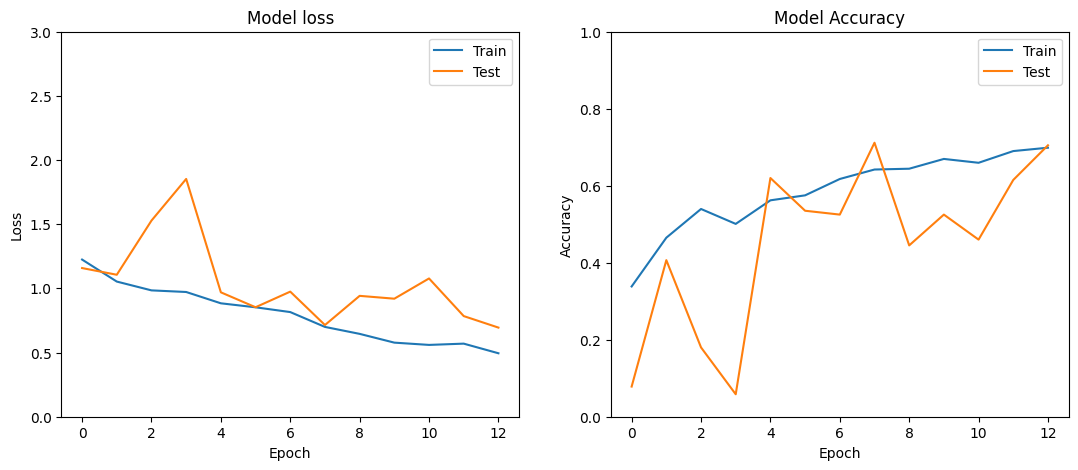

In [ ]:
# Metricas para evaluar el modelo

def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(13,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    if title:
        fig.suptitle(title)

plot_loss_accuracy(history)

# Load the model and data to be predicted

In [ ]:
# definir la arquitectura con las que vamos a trabajar
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.3))  # Reducir el dropout para evitar perder demasiadas características
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))


In [ ]:
model.load_weights("./weight.hdf5")

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
import pickle

with open('./X_predict.pkl','rb') as f:
    X_predict = pickle.load(f)

In [ ]:
X_predict.shape

(960, 224, 224, 3)

In [ ]:
# extracting features for validation frames
X_predict = base_model.predict(X_predict)
X_predict.shape

30/30 [==============================] - 50s 2s/step


(960, 7, 7, 512)

In [ ]:
X_predict = X_predict.reshape(960, 7*7*512)

In [ ]:
max = X_predict.max()
X_predict = X_predict/max

In [ ]:
prediction = model.predict(X_predict)

30/30 [==============================] - 0s 8ms/step


In [ ]:
pd.DataFrame(prediction)

,0,1,2
0,0.691017,0.296816,0.012167
1,0.561684,0.427358,0.010958
2,0.269912,0.644980,0.085108
3,0.179288,0.801774,0.018937
4,0.228696,0.745158,0.026147
...,...,...,...
955,0.736970,0.257754,0.005276
956,0.751981,0.245408,0.002611
957,0.768846,0.228509,0.002646
958,0.744805,0.253474,0.001721


In [ ]:
np.argmax(prediction, axis=1)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [ ]:
predict_data = pd.read_csv('./predict_new.csv')
predict_data.head()

,image
0,test_1\019d5b34_0.mp4_frame0.jpg
1,test_1\019d5b34_0.mp4_frame1.jpg
2,test_1\019d5b34_0.mp4_frame10.jpg
3,test_1\019d5b34_0.mp4_frame11.jpg
4,test_1\019d5b34_0.mp4_frame12.jpg
